# Rossman Store Sales

https://jovian.com/aakashns/python-gradient-boosting-machines

## Download data

In [133]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the competition name
competition_name = "rossmann-store-sales"

# Download the competition data
# api.competition_download_files(competition_name, path="./data", force=True)

In [140]:
import os
from pathlib import Path
import zipfile

BASE_PATH = Path(f"../data/{competition_name}")
# ZIP_FILE = str(BASE_PATH) + ".zip"

# with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
#     zip_ref.extractall(BASE_PATH)
    
# os.remove(ZIP_FILE)

## Data wrangling

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)

In [142]:
df_kwargs = dict(
    parse_dates=["Date"], 
    dtype={"StateHoliday": str}
)

ross_df = pd.read_csv(BASE_PATH / "train.csv", **df_kwargs)
store_df = pd.read_csv(BASE_PATH / "store.csv")
test_df = pd.read_csv(BASE_PATH / "test.csv", **df_kwargs)
submission_df = pd.read_csv(BASE_PATH / "sample_submission.csv")

In [4]:
ross_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_df = pd.merge(
    ross_df,
    store_df,
    how="left",
    on="Store",
)

test_df = pd.merge(
    test_df,
    store_df,
    how="left",
    on="Store",
)

In [7]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

## Feature engineering

In [9]:
def split_date(df: pd.DataFrame, column: str = "Date") -> None:
    dt = df[column].dt
    df["Year"] = dt.year
    df["Month"] = dt.month
    df["Day"] = dt.day
    df["WeekOfYear"] = dt.isocalendar().week
    df.drop(column, axis=1, inplace=True)
    
split_date(train_df)
split_date(test_df)


In [10]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [11]:
train_df[train_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

In [12]:
train_df = train_df[(train_df.Open == 1) & (train_df.Sales > 0)].copy()

In [13]:
# Calculate the number of months since the competition was opened
def competition_months(df):
    df["CompetitionOpenInMonths"] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (
        df.Month - df.CompetitionOpenSinceMonth
    )
    df["CompetitionOpenInMonths"] = (
        df["CompetitionOpenInMonths"].map(lambda x: 0 if x < 0 else x).fillna(0)
    )

In [14]:
competition_months(train_df)
competition_months(test_df)

In [15]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpenInMonths
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0


In [16]:
def check_promo_month(row):
    month2str = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sept",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    try:
        months = (row["PromoInterval"] or "").split(",")
        if row["Promo2OpenInMonths"] > 0 and month2str[row["Month"]] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0


def promo_cols(df):
    # Months since Promo2 was open
    df["Promo2OpenInMonths"] = (
        12 * (df.Year - df.Promo2SinceYear)
        + (df.WeekOfYear - df.Promo2SinceWeek) * 7 / 30.5
    )
    df["Promo2OpenInMonths"] = (
        df["Promo2OpenInMonths"].map(lambda x: 0 if x < 0 else x).fillna(0) * df["Promo2"]
    )
    # Whether a new round of promotions was started in the current month
    df["IsPromo2Month"] = df.apply(check_promo_month, axis=1) * df["Promo2"]

In [17]:
promo_cols(train_df)
promo_cols(test_df)

In [18]:
train_df.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpenInMonths,Promo2OpenInMonths,IsPromo2Month
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0
5,6,5,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN,2015,7,31,31,19.0,0.000000,0
6,7,5,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,7,31,31,27.0,0.000000,0
7,8,5,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,7,31,31,9.0,0.000000,0
8,9,5,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,7,31,31,179.0,0.000000,0
9,10,5,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0


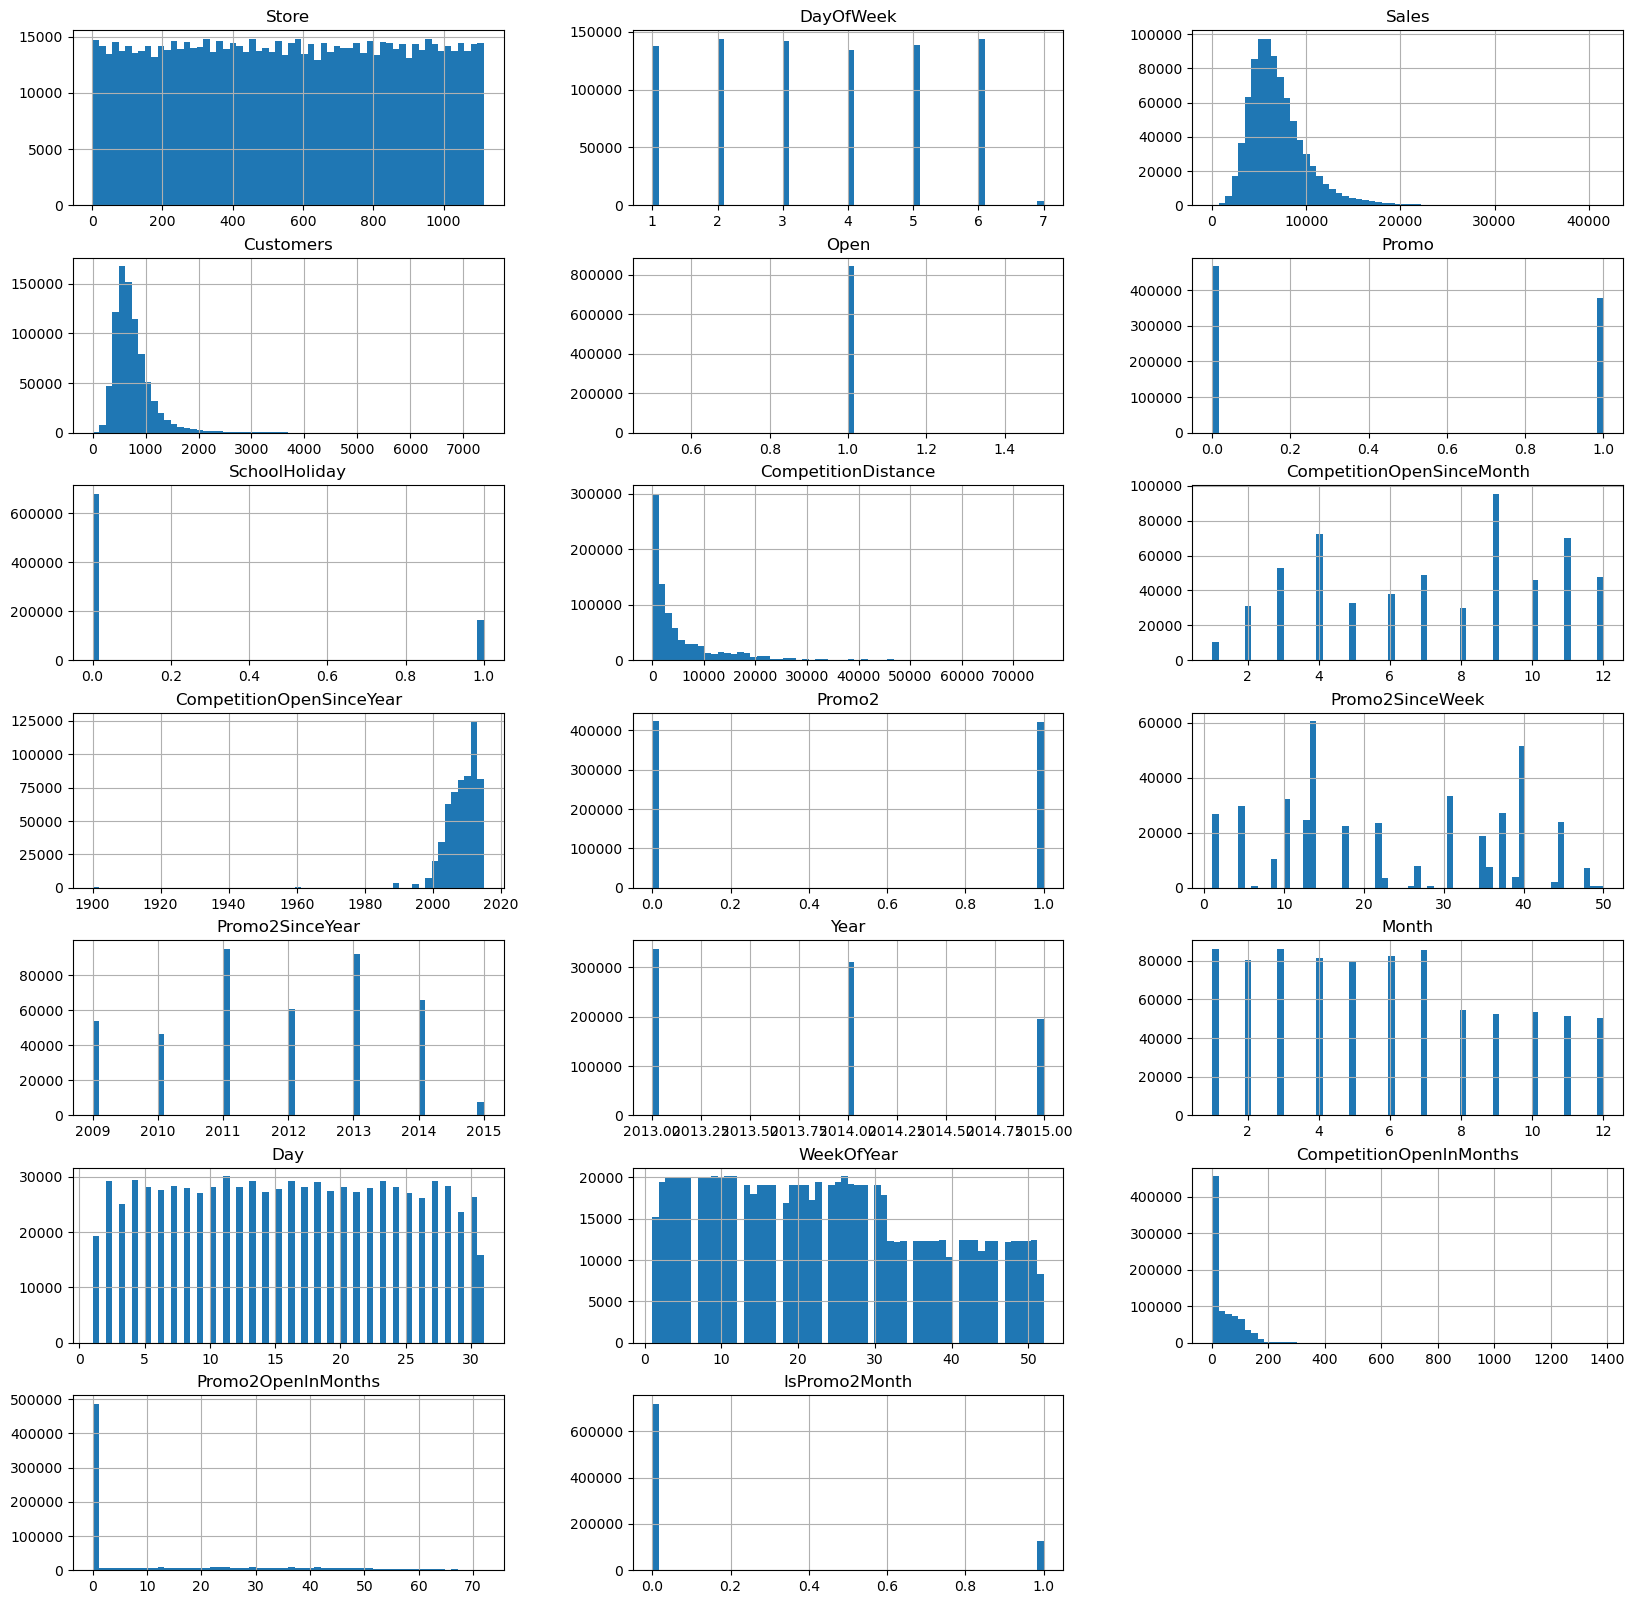

In [37]:
numeric_cols = train_df.select_dtypes(np.number).columns

train_df.hist(column=numeric_cols, layout=(7, 3), sharex=False, bins=60, figsize=(20, 20))
plt.show()

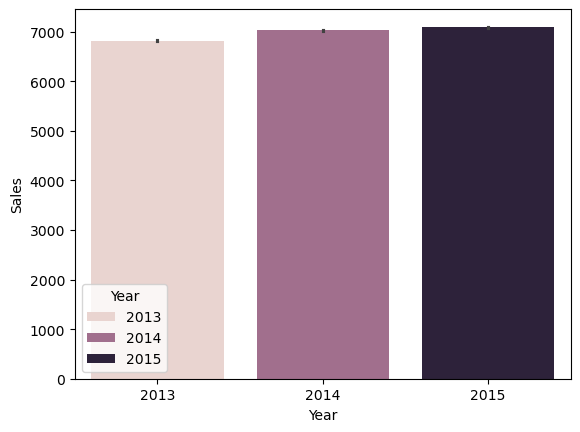

In [38]:
sns.barplot(x="Year", y="Sales", hue="Year", data=train_df)
plt.show()

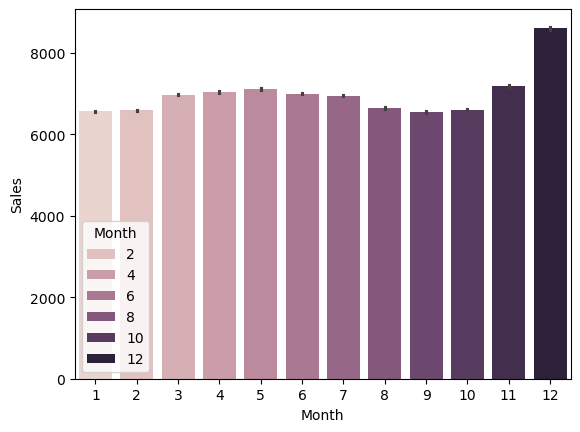

In [39]:
sns.barplot(x="Month", y="Sales", hue="Month", data=train_df)
plt.show()

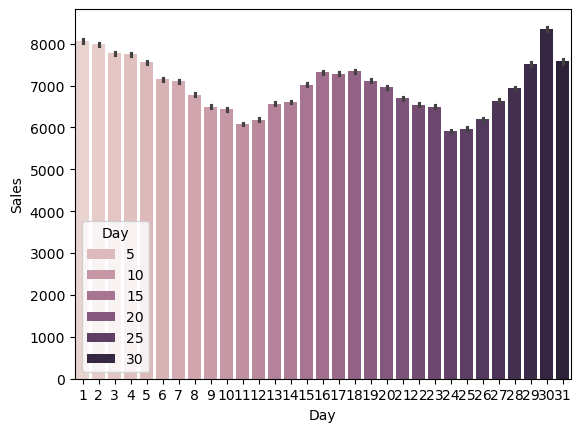

In [40]:
sns.barplot(x="Day", y="Sales", hue="Day", data=train_df)
plt.show()

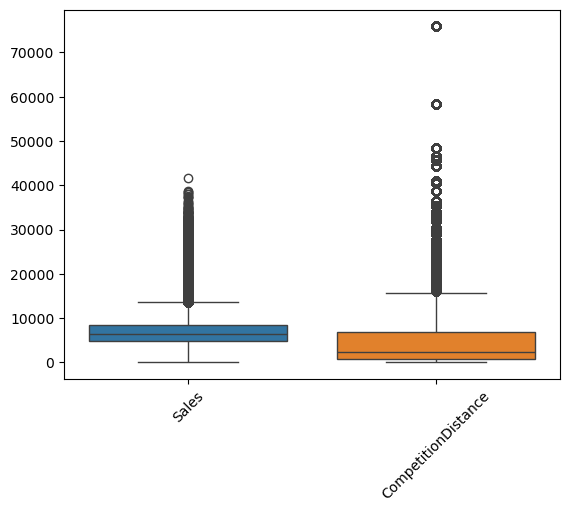

In [41]:
# plot box plots for features
sns.boxplot(data=train_df[["Sales", "CompetitionDistance"]])
# plt.yscale("log")
plt.xticks(rotation=45)
plt.show()

Count Plots:

* Show the number of occurrences in each category.

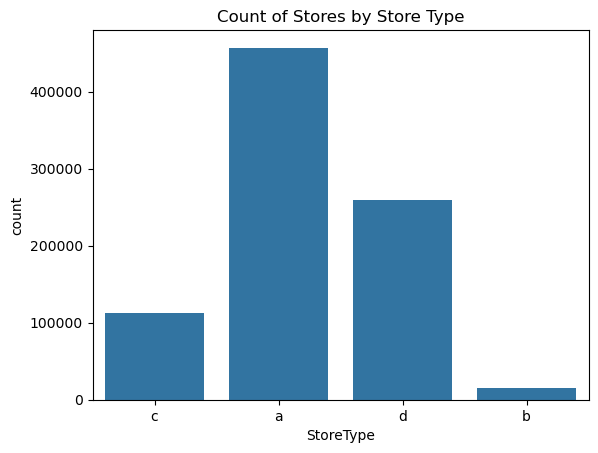

In [42]:
# Create a count plot
sns.countplot(x="StoreType", data=train_df)
plt.title("Count of Stores by Store Type")
plt.show()

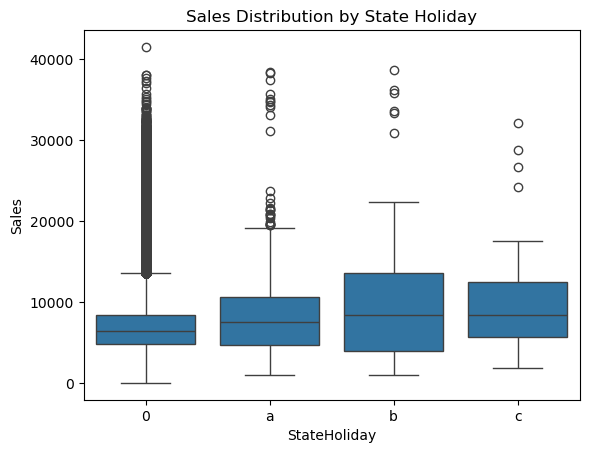

In [43]:
# Create a count plot
sns.boxplot(x="StateHoliday", y="Sales", data=train_df)
plt.title("Sales Distribution by State Holiday")
plt.show()

Point Plots:

* Visualize central tendency (mean or median) for each category.
* Combine with error bars to show variability.

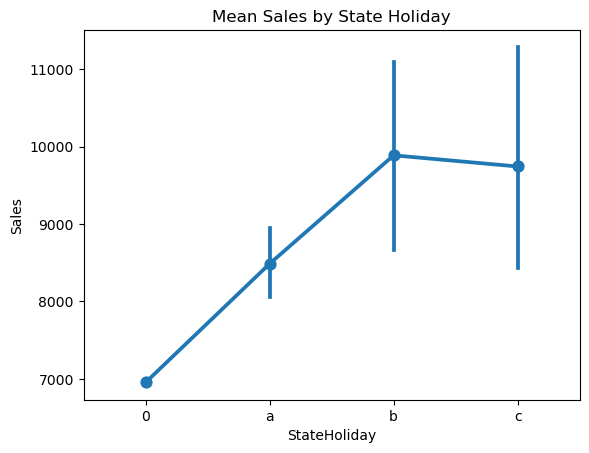

In [44]:
# Create a point plot
sns.pointplot(x="StateHoliday", y="Sales", estimator="mean", data=train_df)
plt.title("Mean Sales by State Holiday")
plt.show()

In [21]:
input_cols = [
    "Store",
    "DayOfWeek",
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
    "StoreType",
    "Assortment",
    "CompetitionDistance",
    "CompetitionOpenInMonths",
    "Day",
    "Month",
    "Year",
    "WeekOfYear",
    "Promo2",
    "Promo2OpenInMonths",
    "IsPromo2Month",
]
target_col = "Sales"

In [22]:
X_train = train_df[input_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[input_cols].copy()

In [23]:
X_train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInMonths,Day,Month,Year,WeekOfYear,Promo2,Promo2OpenInMonths,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0


In [24]:
numeric_features = [
    "Store",
    "CompetitionDistance",
    "CompetitionOpenInMonths",
    "Promo2OpenInMonths",
    "Day",
    "Month",
    "Year",
    "WeekOfYear",
    "DayOfWeek",
]
categorical_features = [
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
    "StoreType",
    "Assortment",
    "Promo2",
    "IsPromo2Month",
]

In [25]:
X_train[numeric_features].isna().sum()

Store                         0
CompetitionDistance        2186
CompetitionOpenInMonths       0
Promo2OpenInMonths            0
Day                           0
Month                         0
Year                          0
WeekOfYear                    0
DayOfWeek                     0
dtype: int64

In [26]:
X_test[numeric_features].isna().sum()

Store                       0
CompetitionDistance        96
CompetitionOpenInMonths     0
Promo2OpenInMonths          0
Day                         0
Month                       0
Year                        0
WeekOfYear                  0
DayOfWeek                   0
dtype: int64

In [27]:
max_distance = X_train.CompetitionDistance.max()
max_distance

75860.0

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.compose import make_column_selector, make_column_transformer

def safe_log1p(x):
    # Set a minimum value to avoid negative or zero values
    x_safe = np.maximum(x, 1e-7)
    return np.log1p(x_safe)

# Create transformers
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=max_distance)),
        # ("imputer", SimpleImputer(strategy="mean")),
        # ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler()),
        # ("scaler", MinMaxScaler()),
        # ("transformer", QuantileTransformer(output_distribution="normal")),
        # ("transformer", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False),
        ),
    ]
)

# Create a column transformer with passthrough
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("function", FunctionTransformer(np.log1p, validate=True), numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Create a pipeline
preproc_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform your data
X_train_preproc = preproc_pipeline.fit_transform(X_train)
X_test_preproc = preproc_pipeline.transform(X_test)

y_train_log = np.log1p(y_train)

In [47]:
X_train_preproc.head()

,Store,CompetitionDistance,CompetitionOpenInMonths,Promo2OpenInMonths,Day,Month,Year,WeekOfYear,DayOfWeek,Promo_1,StateHoliday_a,StateHoliday_b,StateHoliday_c,SchoolHoliday_1,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,Promo2_1,IsPromo2Month_1
0,-1.732571,-0.509325,0.614302,-0.686973,1.746357,0.347245,1.502764,0.510986,0.85841,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.729463,-0.590903,0.767700,2.690576,1.746357,0.347245,1.502764,0.510986,0.85841,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-1.726355,0.989366,0.936438,2.046494,1.746357,0.347245,1.502764,0.510986,0.85841,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-1.723247,-0.585076,0.430225,-0.686973,1.746357,0.347245,1.502764,0.510986,0.85841,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.720139,2.828351,-0.597541,-0.686973,1.746357,0.347245,1.502764,0.510986,0.85841,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


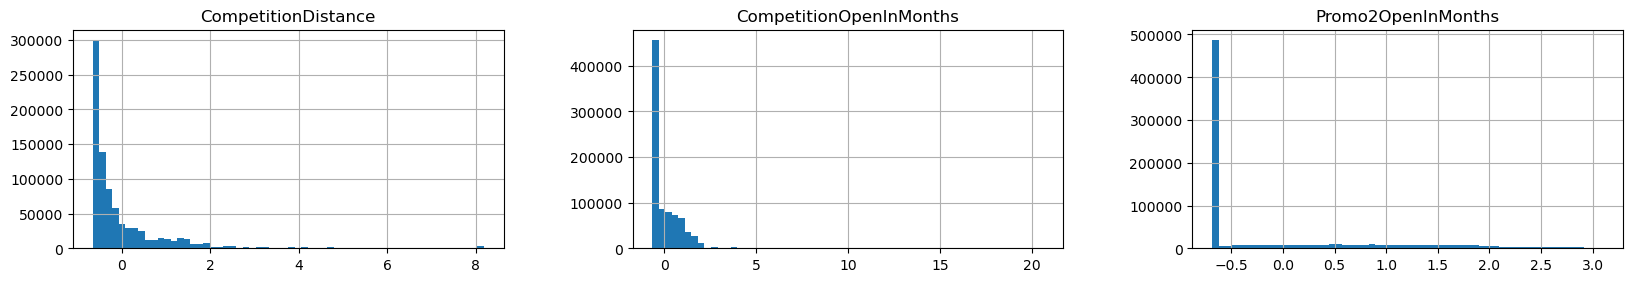

In [48]:
X_train_preproc[
    ["CompetitionDistance", "CompetitionOpenInMonths", "Promo2OpenInMonths"]
].hist(layout=(7, 3), sharex=False, bins=60, figsize=(20, 25))
plt.show()

## Model

In [98]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold  # You can also use other cross-validation strategies

In [73]:
N_JOBS = 4
RANDOM_STATE = 42

In [70]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean((y_pred / y_true - 1) ** 2))

def rmspe_exp(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return rmspe(y_true, y_pred)

def cv_score(model, X, y, k=5):
    # Create a KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

    scorer = make_scorer(rmspe_exp, greater_is_better=False)

    # Perform cross-validation using cross_val_score
    cross_val_results = cross_validate(
        estimator=model,
        X=X,
        y=y,
        cv=kf,
        scoring=scorer,
        return_train_score=True,
        return_estimator=True,
        n_jobs=N_JOBS,
    )
    train_rmspe = -1 * cross_val_results["train_score"]
    test_rmspe = -1 * cross_val_results["test_score"]
    return {
        "cv_results": cross_val_results,
        "score_mean": {
            "train": train_rmspe.mean(),
            "test": test_rmspe.mean(),
        },
        "scores": {
            "train": train_rmspe,
            "test": test_rmspe,
        }
    }

## Baseline model

In [74]:
lr = LinearRegression(n_jobs=N_JOBS)

In [75]:
cv_scores = cv_score(lr, X_train_preproc, y_train_log)
cv_scores

{'cv_results': {'fit_time': array([1.14139128, 1.13858867, 1.14222193, 1.15378428, 0.42560005]),
  'score_time': array([0.03257823, 0.02437544, 0.03337574, 0.03625894, 0.01641512]),
  'estimator': [LinearRegression(n_jobs=4),
   LinearRegression(n_jobs=4),
   LinearRegression(n_jobs=4),
   LinearRegression(n_jobs=4),
   LinearRegression(n_jobs=4)],
  'test_score': array([-0.44232704, -0.46797034, -0.45307221, -0.436091  , -0.51820506]),
  'train_score': array([-0.46979357, -0.46373821, -0.46695796, -0.47095898, -0.44997777])},
 'score_mean': {'train': 0.46428529792102, 'test': 0.46353312901050076},
 'scores': {'train': array([0.46979357, 0.46373821, 0.46695796, 0.47095898, 0.44997777]),
  'test': array([0.44232704, 0.46797034, 0.45307221, 0.436091  , 0.51820506])}}

In [76]:
cv_scores["cv_results"]["estimator"][3].score(X_train_preproc, y_train_log)

0.23041401038168452

In [77]:
y_train.min(), y_train.max()

(46, 41551)

## Grid Search

In [82]:
xgb = XGBRegressor(
    n_estimators=240,
    max_depth=11,
    colsample_bytree=0.9,
    colsample_bynode=0.8,
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS
)

scorer = make_scorer(rmspe_exp, greater_is_better=False)

params = {
    # "n_estimators": [50, 100, 200, 240, 500, 1000],
    # "max_depth": [5, 8, 10, 11, 15],
    # "learning_rate": [0.01, 0.1, 0.5, 0.99, 1],
    # "colsample_bytree": [0.6, 0.8, 0.9, 0.95, 1],
    # "colsample_bynode": [0.6, 0.8, 0.9, 0.95, 1],
    # "subsample": [0.8, 0.9, 1],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring=scorer,
    cv=5,
    n_jobs=N_JOBS,
    verbose=3,
    return_train_score=True,
)

grid_search.fit(X_train_preproc, y_train_log)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=0.8, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=11, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=240,
                                    n_jobs=4, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=4, param_grid={}, return_train_score=True,
             scoring=make_scorer(rmspe_exp, greater_is_better=False, response_method='predict'),
             verbose=3)

In [84]:
grid_search.best_params_, -1 * grid_search.best_score_

({}, 0.22274652441536488)

## Fine tuning

In [85]:
from sklearn.model_selection import train_test_split

# Setting a valid split size similar to the test set size
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train_preproc, y_train_log, test_size=0.049, random_state=RANDOM_STATE
)

In [86]:
xgb_params = dict(
    n_estimators=240,
    max_depth=11,
    # subsample=0.8,
    # learning_rate=0.5,
    colsample_bytree=0.9,
    colsample_bynode=0.8,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_split, y_train_split)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8, colsample_bytree=0.9,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=240,
             n_jobs=4, num_parallel_tree=None, random_state=42, ...)

In [87]:
xgb.score(X_train_split, y_train_split)

0.9751319221280094

In [88]:
xgb.score(X_valid_split, y_valid_split)

0.9518840899893035

In [92]:
y_preds = xgb.predict(X_valid_split)
rmspe_exp(y_valid_split, y_preds)

0.10952243047624076

## MLFlow experiment

In [101]:
mlflow.set_experiment("Rossmann_XGB-regressor")

xgb_params = dict(
    n_estimators=1000,
    learning_rate=0.2,
    max_depth=9,
    subsample=0.99,
    colsample_bytree=0.99,
    eval_metric=rmspe_exp,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
)

2024/02/08 09:34:40 INFO mlflow.tracking.fluent: Experiment with name 'Rossmann_XGB-regressor' does not exist. Creating a new experiment.


In [102]:
with mlflow.start_run(run_name="XGB_Regressor", description="XGB Regressor"):
    mlflow.log_params(xgb_params)
    mlflow.set_tag("Training Info", "XGB Regressor")
    
    xgb = XGBRegressor(**xgb_params)
    
    validation_results = cv_score(xgb, X_train_preproc, y_train_log)
    print(validation_results["score_mean"])
    
    mlflow.log_metrics(validation_results["score_mean"])
    
    # Infer the model signature
    # signature = infer_signature(X_train_preproc, xgb.predict(X_train_preproc))

    # Log the model
    # model_info = mlflow.sklearn.log_model(
    #     sk_model=xgb,
    #     artifact_path="xgb_model",
    #     signature=signature,
    #     input_example=X_train,
    #     registered_model_name="rossmann_xgb_model",
    # )


{'train': 0.06599005154329096, 'test': 0.15859930221103885}


## Final XGB model

In [104]:
xgb_params = dict(
    n_estimators=600,
    learning_rate=0.11,
    # objective="reg:squarederror",
    # booster="gbtree",
    max_depth=11,
    subsample=0.9,
    colsample_bytree=0.6,
    eval_metric=rmspe_exp,
    early_stopping_rounds=100,
    random_state=RANDOM_STATE,
    device="cuda",
    n_jobs=N_JOBS,
)
xgb = XGBRegressor(**xgb_params)
xgb.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_valid_split, y_valid_split)],
    verbose=True,
)

print(
    f"\nTrain RMSPE: {rmspe_exp(y_train_split, xgb.predict(X_train_split))}"
    f"\nValid RMSPE: {rmspe_exp(y_valid_split, xgb.predict(X_valid_split))}"
)

[0]	validation_0-rmse:0.40624	validation_0-rmspe_exp:0.52902	validation_1-rmse:0.40938	validation_1-rmspe_exp:0.50480
[1]	validation_0-rmse:0.39285	validation_0-rmspe_exp:0.51119	validation_1-rmse:0.39609	validation_1-rmspe_exp:0.48780
[2]	validation_0-rmse:0.38064	validation_0-rmspe_exp:0.49220	validation_1-rmse:0.38395	validation_1-rmspe_exp:0.46988
[3]	validation_0-rmse:0.36939	validation_0-rmspe_exp:0.47321	validation_1-rmse:0.37269	validation_1-rmspe_exp:0.45323
[4]	validation_0-rmse:0.35784	validation_0-rmspe_exp:0.45779	validation_1-rmse:0.36113	validation_1-rmspe_exp:0.43757
[5]	validation_0-rmse:0.34654	validation_0-rmspe_exp:0.43844	validation_1-rmse:0.34989	validation_1-rmspe_exp:0.41953
[6]	validation_0-rmse:0.34081	validation_0-rmspe_exp:0.43139	validation_1-rmse:0.34404	validation_1-rmspe_exp:0.41185
[7]	validation_0-rmse:0.33070	validation_0-rmspe_exp:0.41683	validation_1-rmse:0.33403	validation_1-rmspe_exp:0.39710
[8]	validation_0-rmse:0.32505	validation_0-rmspe_exp:0.4

In [105]:
trees = xgb.get_booster().get_dump()
len(trees)

600

In [106]:
importance_df = pd.DataFrame(
    {"feature": X_train_preproc.columns, "importance": xgb.feature_importances_}
).sort_values("importance", ascending=False)
importance_df.head(10)

,feature,importance
9,Promo_1,0.267487
14,StoreType_b,0.164645
1,CompetitionDistance,0.105093
0,Store,0.080874
19,Promo2_1,0.055652
18,Assortment_c,0.048764
15,StoreType_c,0.047249
16,StoreType_d,0.043070
8,DayOfWeek,0.028505
10,StateHoliday_a,0.024540


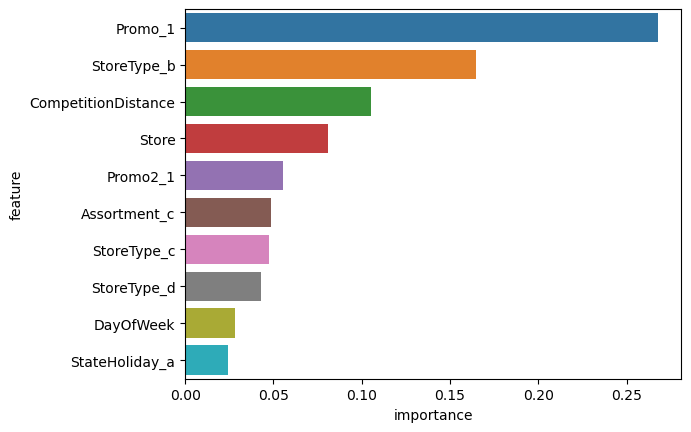

In [107]:
sns.barplot(x="importance", y="feature", hue="feature", data=importance_df.head(10))
plt.show()

## Random Forest

In [108]:
mlflow.set_experiment("Rossmann_RandomForestRegressor")

2024/02/08 09:44:39 INFO mlflow.tracking.fluent: Experiment with name 'Rossmann_RandomForestRegressor' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/dev/ml/projects/ml_sklearn_tutorial/jovian/ml_sklearn_ext/mlruns/179735354497307874', creation_time=1707381879452, experiment_id='179735354497307874', last_update_time=1707381879452, lifecycle_stage='active', name='Rossmann_RandomForestRegressor', tags={}>

In [120]:
from tabnanny import verbose
from sklearn.ensemble import RandomForestRegressor

rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features=0.9,
    min_samples_split=3,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
)

with mlflow.start_run(run_name="RandomForestRegressor", description="Random Forest Regressor"):
    mlflow.set_tag("Training Info", "Random Forest Regressor")
    mlflow.log_params(rf_params)

    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_split, y_train_split)
    
    train_rmspe = rmspe_exp(y_train_split, rf.predict(X_train_split))
    valid_rmspe = rmspe_exp(y_valid_split, rf.predict(X_valid_split))

    mlflow.log_metrics({"test_rmspe": valid_rmspe, "train_rmspe": train_rmspe})
    
    print(
        f"Train RMSPE: {train_rmspe}"
        f"\nValid RMSPE: {valid_rmspe}"
    )

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   56.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Train RMSPE: 0.067270291855647
Valid RMSPE: 0.13224541797459113


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


# MLP

In [126]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16), 
    activation="relu",
    solver="sgd",
    max_iter=200,
    learning_rate="adaptive", # for SGD only
    learning_rate_init=0.001,
    alpha=0.00001, # Regulazation L2
    early_stopping=True,
    # tol=1e-4, # Tolerance for the stopping criterion
    # n_iter_no_change=10, # Number of iterations with no improvement
    verbose=3,
    random_state=42
)
nn.fit(X_train_split, y_train_split)

train_rmspe = rmspe_exp(y_train_split, nn.predict(X_train_split))
valid_rmspe = rmspe_exp(y_valid_split, nn.predict(X_valid_split))

print({"train_rmspe": train_rmspe, "valid_rmspe": valid_rmspe})

Iteration 1, loss = 0.24208239
Validation score: 0.240016
Iteration 2, loss = 0.06676976
Validation score: 0.267001
Iteration 3, loss = 0.06532818
Validation score: 0.277823
Iteration 4, loss = 0.06456149
Validation score: 0.282849
Iteration 5, loss = 0.06399945
Validation score: 0.290651
Iteration 6, loss = 0.06347933
Validation score: 0.297240
Iteration 7, loss = 0.06295002
Validation score: 0.302288
Iteration 8, loss = 0.06246786
Validation score: 0.308799
Iteration 9, loss = 0.06200045
Validation score: 0.314565
Iteration 10, loss = 0.06152424
Validation score: 0.319920
Iteration 11, loss = 0.06104785
Validation score: 0.323608
Iteration 12, loss = 0.06055835
Validation score: 0.330773
Iteration 13, loss = 0.06009718
Validation score: 0.336152
Iteration 14, loss = 0.05969408
Validation score: 0.339973
Iteration 15, loss = 0.05937204
Validation score: 0.340677
Iteration 16, loss = 0.05909089
Validation score: 0.347124
Iteration 17, loss = 0.05881213
Validation score: 0.345733
Iterat

d:\dev\anaconda3\envs\scikit-learn\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'train_rmspe': 0.31508285105111195, 'valid_rmspe': 0.2837092004455036}


## Ensembling

In [ ]:
from sklearn.ensemble import VotingRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42, n_jobs=8)
xgb = XGBRegressor(
    xgb_params
)
lr = LinearRegression(n_jobs=8)

ensemble = VotingRegressor(
    estimators=[
        ("xgb", xgb), 
        ("rf", rf), 
        ("lr", lr),
    ],
    # weights=[2, 1, 1],
    n_jobs=8,
    # voting="soft",
)
ensemble.fit(X_train_preproc, y_train)

In [110]:
cv_score(ensemble, X_train_preproc, y_train)

{'score_mean': {'train': 1003.9741228094914, 'test': 1190.553025913469},
 'scores': {'train': array([1003.2911737 , 1004.68553176, 1004.53323413, 1001.99917624,
         1005.36149822]),
  'test': array([1189.026745  , 1185.51331618, 1190.11966773, 1195.6975265 ,
         1192.40787416])}}

## Kaggle submission

In [61]:
X_test_preproc

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInMonths,Day,Month,Year,WeekOfYear,Promo2,Promo2OpenInMonths,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


In [62]:
test_df.Open.isna().sum()

11

In [99]:
submission_df.head()

,Id,Sales
0,1,4171.212402
1,2,7405.380371
2,3,9272.341797
3,4,6466.091797
4,5,6731.533691


In [155]:
test_preds = xgb.predict(X_test_preproc)

In [156]:
submission_df["Sales"] = np.expm1(test_preds)

In [157]:
submission_df["Sales"] = submission_df["Sales"] * test_df.Open.fillna(1.0)

In [158]:
submission_df.to_csv("submission.csv", index=None)